# Лабораторная работа № 6. Прогнозирование временного ряда на примере температуры блока усиления мощности.

В работе проводится обзор основных методов машинного обучения по прогнозированию временного ряда. В качестве примера рассмотрен ряд температур блока усиления мощности.

## Введение

Современные радиолокационные станции (РЛС) – это структурно-сложные радиотехнические и информационные системы, характеризующиеся высокой надежностью функционирования и большим числом цифровых компонентов в своем составе. Одним из таких компонентов является блок усиления мощности (БУМ), задача которого усиливать передаваемый или принимаемый сигнал.

Функционирование БУМ приводит к их нагреву, что может сказаться на снижении их работоспособности или даже привести к отказу.  Техническое состояние БУМ напрямую зависит от их температуры: при достижении определенного порога блок перестает работать и начинает охлаждаться. После охлаждения до определенной температуры он снова переходит в рабоспособное состояние.

Основная задача, решаемая в рамках данной лабораторной работы - спрогнозировать будущее значение температуры блоков усиления мощности на основании истории их функционирования и режима работы блоков. Последний определяет тип сигнала, передаваемый на БУМ, а поэтому определяет интенсивность нагрева.

Существует 2 основных подхода к прогнозированию временного ряда методами машинного обучения. В обоих подходах обучающая выборка состоит из ретроспективных данных о функционировании блока. Отличие состоит в том, что выбирается в качестве целевой переменной. 

В первом подходе определяется значение временного ряда (температуры) на следующем отсчете времени (целевая переменная - 1-мерная). Тогда прогнозные значения на каком-то интервале времени будут получаться путем последовательного прогнозирования значения ряда на 1 временной отсчет. При этом ошибка неизбежно накапливается, поскольку каждое прогнозное значение имеет свою неустранимую ошибку.

В другом подходе в качестве целевой переменной выбирается сразу интервал значений длиной *n* (целевая переменная *n*-мерная). Такой подход лишен недостатка в виде накопления ошибки, как в первом подходе. Однако, в этом случае сам метод прогнозирования сложнее и требует больших временных затрат и больших вычислительных мощностей.

В данной лабораторной работе мы остановимся на первом подходе.

## Описание файла с данными

Подключим стандартные пакеты для работы с данными и построения графиков

In [129]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Загрузим файл с данными и выведем на экран первые 5 строк. Получим информацию по каждой колонке.

In [130]:
df = pd.read_csv("Lab6_data.csv")
df.head()

,mode,temp1,temp2,temp3
0,3,28.286114,28.043155,27.282141
1,4,34.142434,35.346311,34.829661
2,2,34.813586,36.781106,34.445407
3,4,39.946499,43.133120,40.372435
4,4,43.950857,47.014358,44.162152


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205950 entries, 0 to 1205949
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   mode    1205950 non-null  int64  
 1   temp1   1205950 non-null  float64
 2   temp2   1205950 non-null  float64
 3   temp3   1205950 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 36.8 MB


Первая колонка **mode** обозначает номер режима работы блоков. Этот режим определяет интенсивность нагрева блоков. Следующие 3 колонки содержат в себе информацию о температуре каждого из 3-х БУМ в каждый момент времени.

#### **Задание 1** 

Создадим 3 таблицы, содержащие информацию о режиме работы и температуры каждого из блоков.

In [132]:
tables_count = 3
tables = []

rows_per_table = len(df) // tables_count
for i in range(tables_count):
    tables.append(df.loc[:, ['mode', f'temp{i+1}']].rename(columns={f'temp{i+1}': 'temp'}))


Активный **DataFrame** будем обозначать как **df**. Это позволит довольно легко применять различные методы прогноза для различных блоков без переписывания кода. Достаточно просто будет сделать активной какую-либо из 3-х таблиц.

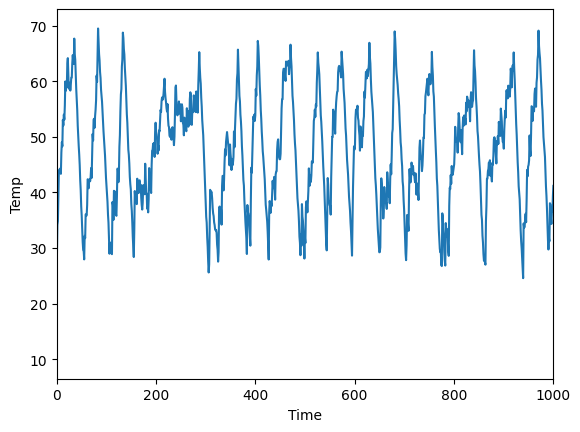

In [133]:
df = tables[0]

plt.plot(df['temp'])
plt.xlim(0,1000)
plt.xlabel('Time')
plt.ylabel('Temp')
plt.show()

## Анализ режимов работы

#### **Задание 2** 

Проанализируем, чем отличаются режимы друг от друга. Поскольку режим работы определяет интенсивность нагрева, то режимом работы определяется то, насколько изменилась температура за один отсчет времени, т.е. производная температуры по времени.

Добавим в таблицу столбец, показывающий разность текущего значения температуры и в предыдущий отсчет времени.

In [134]:
df['delta'] = df['temp'].diff().fillna(0)
df

,mode,temp,delta
0,3,28.286114,0.000000
1,4,34.142434,5.856320
2,2,34.813586,0.671153
3,4,39.946499,5.132913
4,4,43.950857,4.004358
...,...,...,...
1205945,2,18.943890,-0.028962
1205946,4,29.037470,10.093580
1205947,2,30.074717,1.037247
1205948,0,28.349375,-1.725342


#### **Задание 3** 

Зададим функцию, которая выделяет из полученной таблицы значения температуры и ее производной для заданного режима работы.

In [135]:
def select_data(df, mode):
    temp = df.query(f"mode=={mode}")['temp']
    delta_temp = df.query(f"mode=={mode}")['delta']
    return temp, delta_temp

Определим возможные режимы работы блоков.

In [136]:
df['mode'].unique()

array([3, 4, 2, 1, 0], dtype=int64)

Построим 5 графиков, на каждом из которых отобразим характерные особенности каждого из режимов работы. Для этого будем по горизонтальной оси откладывать температуру блока, а по вертикальной оси - изменение температуры за один отсчет времени. Каждый временной отсчет будем откладывать в виде точки на этих графиках.

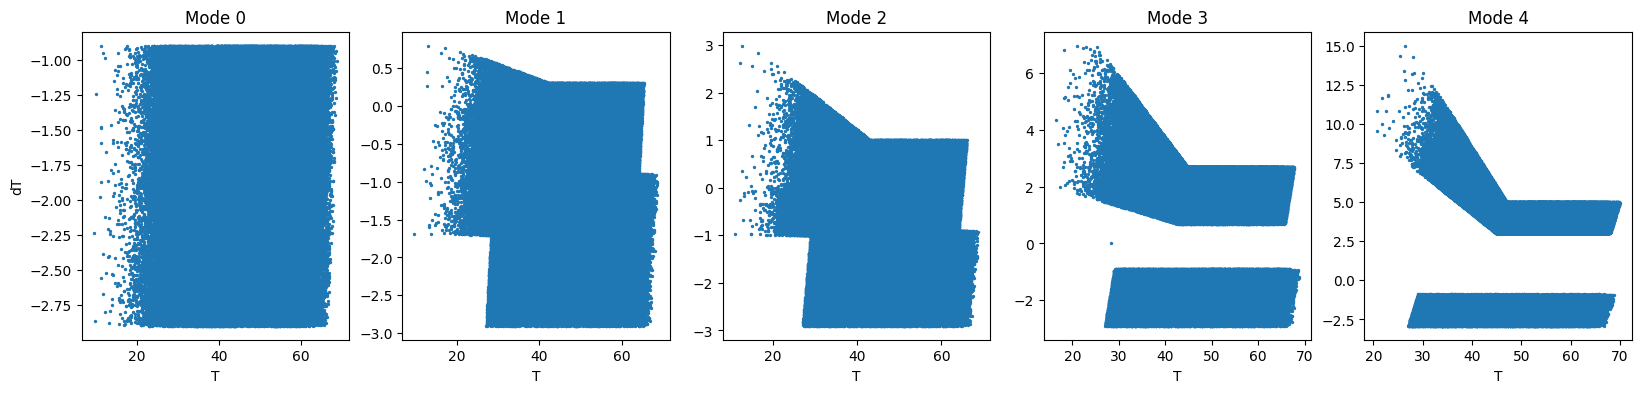

In [137]:
plt.figure(figsize=(20,4))
for mode in range(5):
    plt.subplot(1,5,mode+1)
    x, y = select_data(df, mode)
    plt.scatter(x, y, s=2)
    plt.title('Mode '+str(mode))
    plt.xlabel('T')
    if mode == 0:
        plt.ylabel('dT')
plt.show()

Проанализируем полученные характеристики каждого из режимов работы. Прежде всего на всех графиках присутствует область с изменением температуры от -3 до -1 и температурой от 25 до 70, что соответствует охлаждению блока. В этом состоянии блок не работает, режимы работы не сказываются на температуре блока, поэтому эти области можно исключить из рассмотрени.

Сравнение изменений температур в остальных областях позволяет сделать вывод, что в режиме 0 происходит всегда охлаждение, в режиме 1 - хаотически нагрев и охлаждение, в режимах 2 - 4 - нагрев, при этом увеличение номера режима соответствует увеличению интенсивности нагрева. 

## Подготовка данных

### Нормирование

#### **Задание 4** 

Температура, записанная в таблице **df** измеряется в градусах Цельсия. Однако для применения линейных моделей машинного обучения крайне важно нормировать данные, чтобы ограничить их максимальные и минимальные значения. Отнормируем значения температуры на отрезок \[0,1\]. Сохраненные значения **max_value** и **min_value** позволят после выполнения прогноза вернуться к реальным значениям температуры.  

In [138]:
def normalize(series):
    max_value = series.max()
    min_value = series.min()
    normalized = (series - min_value) / (max_value - min_value)
    return normalized, max_value, min_value

In [139]:
normalized, max_value, min_value = normalize(df['temp'])
df.loc[:,'temp'] = normalized

### Создание тестовой выборки

В качестве тестовой выборки будем использовать последовательность значений температур определенной длины **seq_length** и режим работы в конце этой последовательности. При этом стоит обратить внимание на то, что режим работы в какой-то временной отсчет $mode_i$ определяет значение температуры в тот же самый отсчет времени $T_i$. Поэтому обучающая выборка должна состоять из значений:

$$
X = \{T_{N-seq\_length+1}, ..., T_{N-1}, T_{N}, mode_{N+1}\}.
$$

В то время как целевая переменная является просто последующим значением температуры:

$$
y = T_{N+1}.
$$

#### **Задание 5** 

Напишем функцию, которая будет создавать обучающую и тестовую выборку объемом **N**, где длина обучающей последовательности равна **seq_length**.

In [140]:
def get_sequences(df, N, seq_length):
    if N + seq_length > len(df) - 1:
        N = len(df) - seq_length - 1
    X = []
    y = []
    pos = 1
    while pos < N:
        
        X.append((df['temp'].iloc[pos:pos+seq_length-1]._append(pd.Series([df['mode'].loc[pos+seq_length]]))).values)
        y.append(df['temp'].iloc[pos+seq_length])
        pos += 1

    X = pd.DataFrame(X)
    y = pd.Series(y)
    return X, y

Создадим обучающую и тестовую выборки

In [141]:
size = 10000
seq_length = 40

X, y = get_sequences(df, size, seq_length)

### Кросс-валидация

Для использования моделей машинного обучения с учителем необходимо специальным образом подготовить данные: сформировать обучающую выборку, на которой модель будет "учиться", т.е. подстраивать свои внутренние параметры, тестовую выборку, на которой будет определяться точность модели в процессе ее обучения, а также валидационную выборку, на которой проверяется итогое качество работы модели. 

Вместо выделения валидационной выборки можно использовать механизм кросс-валидации.В основе метода лежит разделение исходного множества данных на **k** примерно равных блоков, например 5. Затем на **k-1**, т.е. на 4-х блоках, производится обучение модели, а 5-й блок используется для тестирования. Процедура повторяется **k** раз, при этом на каждом проходе для проверки выбирается новый блок, а обучение производится на оставшихся.
![Cross-validation](https://wiki.loginom.ru/images/cross-validation.svg)

Кросс-валидация имеет два основных преимущества перед применением одного множества для обучения и одного для тестирования модели:

- Распределение классов оказывается более равномерным, что улучшает качество обучения.
- Если при каждом проходе оценить выходную ошибку модели и усреднить ее по всем проходам, то полученная оценка будет более достоверной.

В дальнейшем в этой лабораторной работе будем использовать разбиение на 5 блоков с помощью метода **[KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=k%20fold#sklearn.model_selection.KFold 'KFold')**.

In [142]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print('Fold {}'.format(i))
    print('Train index: ', train_index)
    print('Test index: ', test_index)

Fold 1
Train index:  [   0    1    3 ... 9996 9997 9998]
Test index:  [   2   22   29 ... 9976 9979 9981]
Fold 2
Train index:  [   0    1    2 ... 9996 9997 9998]
Test index:  [  16   17   28 ... 9986 9987 9990]
Fold 3
Train index:  [   0    1    2 ... 9995 9996 9998]
Test index:  [   3    8   11 ... 9992 9993 9997]
Fold 4
Train index:  [   1    2    3 ... 9995 9996 9997]
Test index:  [   0    4    5 ... 9989 9994 9998]
Fold 5
Train index:  [   0    2    3 ... 9994 9997 9998]
Test index:  [   1   13   14 ... 9988 9995 9996]


## Линейные модели машинного обучения

Задача прогнозирования температуры является задачей регрессии. Среди линейных моделей будем использовать линейную регрессию, линейную регрессию с L1 и L2-регуляризацией, а также логистическую регрессию. Подробное описание работы этих моделей можно прочитать на сайте [Scikit Learn](https://scikit-learn.org/stable/modules/linear_model.html 'Scikit Learn').

#### **Задание 6** 

Сделаем процесс обучения различных моделей универсальным. Для этого напишем функцию **regr_mape(y_pred, y_test)**, которая будет считать точность спрогнизорованных значений температуры как средний по выборке модуль ошибки прогноза (метрика **MAPE**):

$$
MAPE = \dfrac{1}{N}\sum^{N}_{i=1}\left|\dfrac{y^{pred}_i-y^{test}_i}{y^{test}_i}\right|
$$

Также напишем функцию **train(model, model_name, evaluate, kfold, X, y)**, которая будет обучать заданную модель **model** с использованием механизма кросс-валидации **kfold**. Переменная **evaluate** обозначает метод, который используется для оценки точности пронозных значений (например, **regr_mape()**).

In [143]:
def regr_mape(y_pred, y_test):
    mape = np.mean(np.abs((y_test - y_pred) / y_test))
    return mape

def train(model, model_name, evaluate, kfold, X, y):
    print('Train model: '+model_name)
    scores = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        scores.append(evaluate(pred, y_test))
        
    mean_score = np.mean(scores)
    print('Mean score = {:.5f}'.format(mean_score))
    return mean_score

### Линейная регрессия

В линейных моделях целевая переменная $\hat{y}$ определяется как линейная комбинация известных переменных (признаков):

$$\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p$$

В модели линейной регрессии коэффициенты $w = (w_1, ..., w_p)$ подбираются таким образом, чтобы минимизировать сумму квадратов отклонений рассчитанных значений целевой переменной от истинных значений:

$$\min_{w} || X w - y||_2^2$$

Важно отметить, что линейные модели чувствительны к абсолютным значениям признаков, поэтому следует перед применением линейных моделей провести нормирование исходных данных (обычно на интервал \[0,1\]). Также применение линейных моделей основано на предположении о линейной независимости признаков, поэтому следует стараться не использовать в качестве признаков коррелированные признаки. В противном случае модель будет чувствительна к шумам, т.е. случайным выбросам в значениях признаков.

Создадим и обучим модель **[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression 'LinearRegression')**. Запишем точность модели в словарь **scores**.

In [144]:
from sklearn import linear_model

lin_reg = linear_model.LinearRegression()

scores = dict()

score = train(lin_reg, 'linear regression', regr_mape, kf, X, y)
scores['linear regression'] = score

Train model: linear regression
Mean score = 0.06555


### Линейная регрессия c L1 и L2 регуляризацией

Если размер обучающей выборки невелик, а число признаков, наоборот, достаточно велико, то коэффициенты модели могут быть подобраны таким образом, чтобы модель максимально точно учитывала все точки из обучающей выборки, при этом вне обучающей выборки модель будет давать большую ошибку. Это явление носит название переобучения. Одним из способов препятствовать переобучению является механизмы регуляризации. Он ограничивает значения коэффицентов $w = (w_1, ..., w_p)$, используемых в модели.

L1-регуляризация вносит дополнительный "штраф", пропорциональный модулю значения коэффициента:
$$\min_{w} ||X w - y||_2 ^ 2 + \alpha ||w||_1$$

L2-регуляризация вносит дополнительный "штраф", пропорциональный квадрату модуля значения коэффициента:
$$\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$$

Параметр $\alpha$ задает "силу" регуляризации. L1-регуляризация приведет к тому, что все несущественные признаки будут иметь вес, равный 0. L2-регуляризация приведет к тому, что несущественные признаки будут иметь околонулевые веса. Продемонстрируем это на примере. Создадим и обучим модели **[Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso 'Lasso')** (L1-регуляризация) и **[Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge 'Ridge')** (L2-регуляризация).

In [145]:
# Обучим модель для различных значений параметра регуляризации. Затем выберем оптимальное значение
for alpha in [1e-4, 1e-3, 0.01, 0.1, 1]:
    print('Alpha = {}'.format(alpha))
    lasso = linear_model.Lasso(alpha=alpha)
    score = train(lasso, 'lasso', regr_mape, kf, X, y)

Alpha = 0.0001
Train model: lasso
Mean score = 0.06592
Alpha = 0.001
Train model: lasso
Mean score = 0.07089
Alpha = 0.01
Train model: lasso
Mean score = 0.12246
Alpha = 0.1
Train model: lasso
Mean score = 0.25869
Alpha = 1
Train model: lasso
Mean score = 0.25866


In [146]:
# Выберите оптимальное значение параметра, обучите модель и добавьте значения метрики качества в словарь
lasso = linear_model.Lasso(alpha=0.0001)

score = train(lasso, 'lasso', regr_mape, kf, X, y)
scores['lasso'] = score
print('Coefficients: ', lasso.coef_)

Train model: lasso
Mean score = 0.06593
Coefficients:  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.10629942e-02
 -0.00000000e+00 -0.00000000e+00 -1.04264749e-02 -0.00000000e+00
 -4.78752571e-03 -6.49187436e-04 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.65172723e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.54508173e-02
 -2.59250714e-02 -1.83807694e-04 -2.18258763e-02 -5.80568217e-03
 -1.54790934e-02 -2.39948403e-02 -0.00000000e+00 -0.00000000e+00
 -2.77514195e-02 -2.18930109e-02 -5.08146099e-02 -0.00000000e+00
 -9.06255903e-03 -0.00000000e+00  1.03339975e+00  1.78388701e-02]


#### **Задание 7** 

In [147]:
# Обучим модель Ridge для различных значений параметра регуляризации. Затем выберем оптимальное значение
# Обучим модель для различных значений параметра регуляризации. Затем выберем оптимальное значение
for alpha in [1e-4, 1e-3, 0.01, 0.1, 1]:
    print('Alpha = {}'.format(alpha))
    ridge = linear_model.Ridge(alpha=alpha)
    score = train(ridge, 'ridge', regr_mape, kf, X, y)

Alpha = 0.0001
Train model: ridge
Mean score = 0.06555
Alpha = 0.001
Train model: ridge
Mean score = 0.06556
Alpha = 0.01
Train model: ridge
Mean score = 0.06554
Alpha = 0.1
Train model: ridge
Mean score = 0.06554
Alpha = 1
Train model: ridge
Mean score = 0.06580


In [156]:
# Выберите оптимальное значение параметра, обучите модель и добавьте значения метрики качества в словарь
ridge = linear_model.Ridge(alpha=0.01)

score = train(ridge, 'ridge', regr_mape, kf, X, y)
scores['ridge'] = score
print('Coefficients: ', lasso.coef_)

Train model: ridge
Mean score = 0.06550
Coefficients:  [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.10629942e-02
 -0.00000000e+00 -0.00000000e+00 -1.04264749e-02 -0.00000000e+00
 -4.78752571e-03 -6.49187436e-04 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.65172723e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.54508173e-02
 -2.59250714e-02 -1.83807694e-04 -2.18258763e-02 -5.80568217e-03
 -1.54790934e-02 -2.39948403e-02 -0.00000000e+00 -0.00000000e+00
 -2.77514195e-02 -2.18930109e-02 -5.08146099e-02 -0.00000000e+00
 -9.06255903e-03 -0.00000000e+00  1.03339975e+00  1.78388701e-02]


Наглядно видно, что **Lasso** для параметра $\alpha>0.1$ просто занулила все коэффициенты, давая всегда прогноз 0. Конечно, такая работа модели нас не устраивает. 

## Наглядное изображение прогнозных значений

Давайте посмотрим, какие значения будет выдавать модель, если попросить ее прогнозировать последовательно **forecast_size** значений температуры. Для этого напишем функцию **seq_forecast(model, sample, future_modes)**, которая для заданной модели **model** на основании начального элемента из обучающей выборки **sample** и будущих режимов работы **future_modes** будет последовательно прогнозировать значение температуры в следующий момент времени. Поэтому после очередного спрогнозированного значения температуры необходимо в **sample** добавить это значение, а также новый режим работы.

Функция **plot_forecast(init_temp, true_temp, forecast_temp)** будет наглядно изображать начальный временной ряд **init_temp**, реальное **true_temp** и спрогнозированное **forecast_temp** значения температур в последующие отсчеты времени. Параметр **model_name** обозначает название модели и будет отображаться в названии рисунка.

#### **Задание 8** 

In [149]:
def seq_forecast(model, sample, future_modes):
    
    init_size = len(sample)
    pred = model.predict(np.array(sample).reshape(1, -1))
    y_pred = [pred[0]]
    for new_mode in future_modes:
        # Напишите свой код здесь
        sample[init_size-1] = y_pred[-1]
        sample[init_size] = new_mode
        sample = sample.drop(0, axis=0)
        sample = sample.reset_index(drop=True)
        
        pred = model.predict(np.array(sample).reshape(1, -1))
        y_pred.append(pred[0])
    return y_pred[:-1]

def plot_forecast(init_temp, true_temp, forecast_temp, model_name):
    plt.figure(figsize=(5,5))
    x1 = np.linspace(start=0, stop=len(init_temp), num=len(init_temp), endpoint=False)
    x2 = np.linspace(start=len(init_temp), stop=len(init_temp)+len(true_temp), num=len(true_temp), endpoint=False)
    plt.plot(x1, init_temp, c='black')
    plt.plot(x2, true_temp, c='red', label='true')
    plt.plot(x2, forecast_temp, c='red', linestyle='--', label='pred')
    plt.legend()
    plt.ylim([0, 1])
    plt.xlabel('timestamp')
    plt.ylabel('normalized temp')
    plt.title(model_name)
    plt.show()

Посмотрим на прогнозы линейных моделей

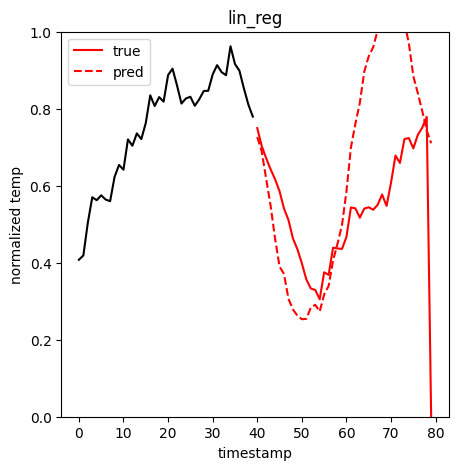

In [155]:
y_pred = seq_forecast(lin_reg, X.iloc[0].copy(), df.loc[2+seq_length:1+2*seq_length, 'mode'])
plot_forecast(X[0][:seq_length], X.iloc[seq_length][:seq_length], y_pred, 'lin_reg')

#### **Задание 9** 

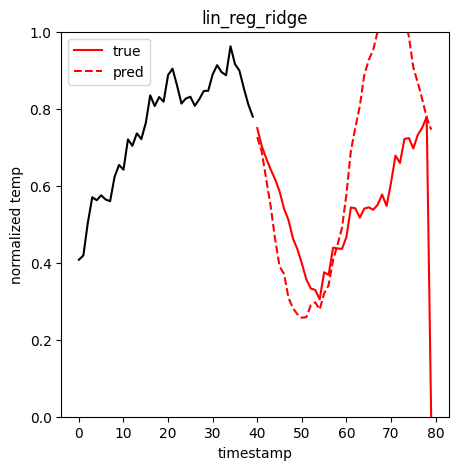

In [157]:
# Постройте анаолгичный график для модели Ridge
y_pred = seq_forecast(ridge, X.iloc[0].copy(), df.loc[2+seq_length:1+2*seq_length, 'mode'])
plot_forecast(X[0][:seq_length], X.iloc[seq_length][:seq_length], y_pred, 'lin_reg_ridge')


**Вывод:** сделайте вывод

## Метод опорных векторов

Этот метод применим для решения как задач классификации, так и регрессии, и кластеризации. Основными достоинствами метода являются:

- эффективность при большой размерности пространства признаков
- в процессе обучения запоминается только подвыборка обучающей выборки - опорные вектора, т.е. требует меньший объем памяти
- можно применять разные ядра (kernels) для формирования модели

Недостатком метода опорных векторов является то, что в случае, когда размерность пространства признаков много больше объема обучающей выборки, на результат работы модели сильно влияет выбор ядра. Также этот метод не позволяет быстро и просто получить вероятность прогноза.

С математической точки зрения, метод опорных векторов проводит гипер-плоскость, которая разделяет один класс от другого. При этом граница проводится так, что быть расположенной максимально далеко от каждой из точек.
![SVC](https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

Функция ядра определяет, какие признаки будут использоваться в качестве переменных в гиперпространстве, в котором проводится гипер-плоскость. Например, для линейного ядра $\langle x, x'\rangle$ берутся исходные признаки, для полиномиального ядра - полиномы от исходных признаков $(\gamma \langle x, x'\rangle + r)^d$, для radial-basis-function (rbf) - экспоненциальная функция $\exp(-\gamma \|x-x'\|^2)$.

Построим модель Support Vector Regression - [**SVR**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR 'SVR') для различных ядер. Заранее уменьшим размер выборки, что позволит проводить обучения в разумное время (метод опорных векторов довольно долго обучается).

In [152]:
from sklearn.svm import SVR
X_svr = X[:10000, :]
y_svr = y[:10000]

KeyError: (slice(None, 10000, None), slice(None, None, None))

#### **Задание 10** 

In [ ]:
# Подберите оптимальное значение параметра регуляризации C и типа ядра (rbf, poly и т.д.). 
# Добавьте качество модели для оптимальных параметров в словарь.


#### **Задание 11** 

Посмотрим на результаты прогноза (постройте график)

In [ ]:
# Напишите свой код здесь


**Вывод:** сделайте вывод

## Дерево решений

В модели дерева решений (Decision Tree) в процессе обучения строится алгоритм, по которому выполняется прогноз модели. При этом алгоритм представляет из себя дерево, каждый лист которого - это проверка на то, что какой-либо признак из обучающей выборки принимает определенное значение. Пример дерева решений приведен на рисунке ниже.
![Decision Tree](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_dtc_0021.png)

Преимуществами такого метода являются:
- простота визуализации и хорошая интерпретируемость алгоритма прогноза
- не требуется нормализация данных
- скорость прогноза пропорциональна логарифму объема выборки, т.е. этот метод быстрый
- может обрабатывать как числовые, так и категориальные данные

Недостатками метода являются:
- деревья легко переобучаются
- небольшие изменения в обучающей выборке могут привести к перестойке всего дерева, т.е. метод нестабилен
- предсказания деревьев являются кусочно-постоянными, поэтому не годятся для экстраполирования
- требуется сбалансировать обучающую выборку по классам, чтобы не допустить "перекоса" дерева в сторону какого-либо класса

Конкретную математическую реализалицаю алгоритма построения дерева решений можно изучить, например, [здесь.](https://scikit-learn.org/stable/modules/tree.html)

Создадим модель [**DecisionTreeRegressor**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor 'DecisionTreeRegressor') и обучим ее. Для того, чтобы предотвратить переобучение дерева, обычно ограничивается максимальная глубина дерева - параметр **max_depth**, а также минимальное число элементов из обучающей выборки, приходящееся на определнный лист, чтобы можно было с него сделать новое ветвление - параметр **min_samples_split**.

#### **Задание 12** 

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Определите оптимальное значение параметра max_depth, min_samples_split и min_samples_leaf
# Добавьте качество модели для оптимальных параметров в словарь.


#### **Задание 13** 

Посмотрим на результаты прогноза (постройте график)

In [ ]:
# Напишите свой код здесь


**Вывод:** сделайте вывод

## Сравнение различных моделей

Отобразим на графике точность работы каждой построенной модели. Для этого будем использовать значения из словаря **scores**.

In [ ]:
plt.figure(figsize=(10,5))
xx = list(scores.keys())
yy = list(scores.values())
rects = plt.bar(xx, yy)
plt.ylim(0, 0.2)
plt.ylabel('MAPE')
for i, rect in enumerate(rects):
    yloc = rect.get_height()
    xloc = rect.get_x() + rect.get_width() / 4
    plt.annotate(round(yy[i], 4), xy=(xloc, yloc), xytext=(xloc, 10),
                            textcoords="offset points",
                            va='center',
                            color='black', clip_on=True)

#### **Задание 14** 

Для наглядности еще раз продемонстрируем результаты прогноза каждой из построенной модели, но на существенно более длительном интервале времени.

In [ ]:
models = [lin_reg, svr, dtr]
model_names = ['linear regr', 'svr', 'decision tree']

# Глубина прогноза
pred_length = 5*seq_length

for model, model_name in zip(models,model_names):
    # Напишите свой код здесь
    print(model_name+' MAPE: ', regr_mape(y_true, y_pred))

## Выводы

#### **Задание 15** 

Сделайте выводы

В дальнешем мы остановимся на методе *Decision Tree* и попробуем сделать прогноз еще более точным с использованием ансамблевых моделей.